# Setup

## Imports 

In [60]:
# Standard
import sys
# Third party
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import proplot as plot
# Local                                                                        
sys.path.append('/Users/46h/Research/code/accphys') 
from tools import (
    envelope_analysis as ea,
    plotting as myplt,
    animation as myanim,
    utils)
from tools.utils import show, play
from tools.plotting import save, set_labels

## Settings
Here are the available [stylesheets](https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html) and [color cycles](https://proplot.readthedocs.io/en/latest/cycles.html).

In [61]:
# Plotting
plt_kws = dict(legend=False, xlabel='s / L')
plot.rc['figure.facecolor'] = 'white'
plot.rc['cycle'] = 'default'
plot.rc['style'] = None # https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
plot.rc['savefig.dpi'] = 'figure' # proplot default is 1200, which makes inline animations appear huge
dpi = 500
titles = open('_output/figures/figure_column_titles.txt', 'r').readline().split('/')  
fig_dir = './_output/figures/envelope/'

# Animation
animate = False
skip = 10
fps = 3
anim_dpi = None

In [62]:
width, height = 6, 2.5

def setup_figure(nrows):
    """Convenience function to create two-column figure."""
    h = nrows * height - (0.75 * (nrows - 1))
    figsize = (width, h)
    fig, axes = plot.subplots(nrows=nrows, ncols=2, figsize=figsize, spany=False, aligny=True)
    axes.format(collabels=titles, xlabel='s / L')
    return fig, axes

## Read Data

In [63]:
modes = np.loadtxt('_output/data/modes.txt').astype(int)
env_params_list = [np.load('_output/data/env_params{}.npy'.format(i))
                   for i in (1, 2)]
transfer_matrices = [np.load('_output/data/transfer_matrix{}.npy'.format(i))
                     for i in (1, 2)]
positions = np.load('_output/data/positions.npy')
positions_normed = positions / positions[-1]

In [64]:
stats_list = []

for env_params, mode in zip(env_params_list, modes):
    
    stats = ea.Stats(mode)
    stats.read_env(env_params)

    # Compute phase advance
    beta_x = stats.twiss2D.loc[:, 'bx'].values
    beta_y = stats.twiss2D.loc[:, 'by'].values
    stats.twiss2D['mux'] = utils.get_phase_adv(beta_x, positions, units='deg')
    stats.twiss2D['muy'] = utils.get_phase_adv(beta_y, positions, units='deg')

    # Add position column
    for df in stats.dfs():
        df['s'] = positions
        df['s/L'] = positions_normed
    
    stats_list.append(stats)

# Twiss parameters

## 2D Twiss 

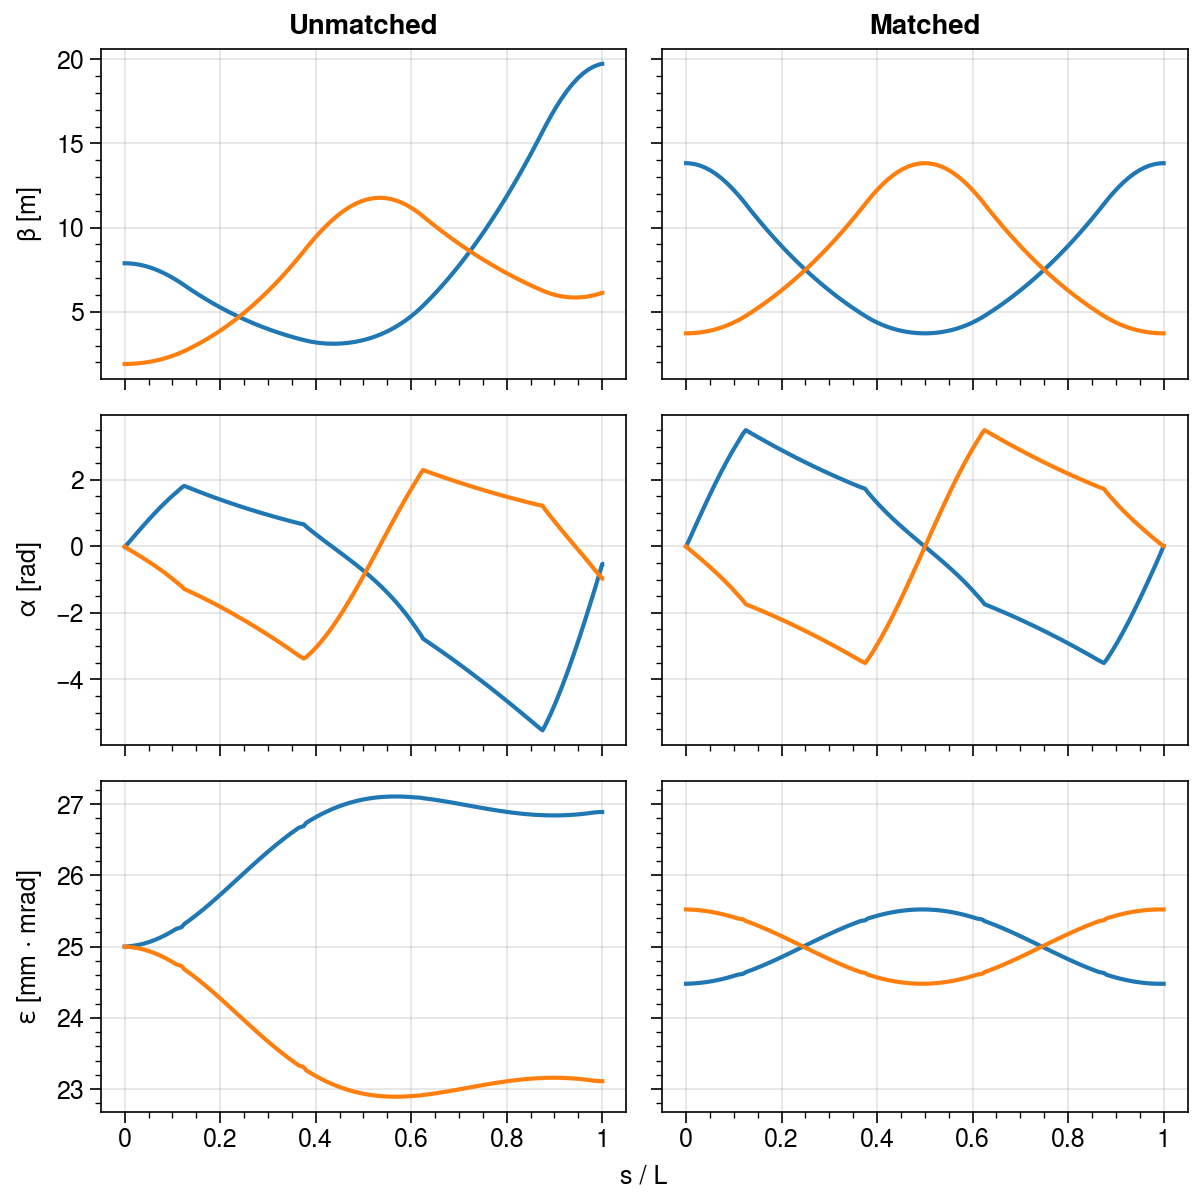

In [65]:
fig, axes = setup_figure(3)
for i, stats in enumerate(stats_list):
    stats.twiss2D[['s/L','bx','by']].plot('s/L', ax=axes[0, i], **plt_kws)
    stats.twiss2D[['s/L','ax','ay']].plot('s/L', ax=axes[1, i], **plt_kws)
    stats.twiss2D[['s/L','ex', 'ey']].plot('s/L', ax=axes[2, i], **plt_kws)
ylabels = [r'$\beta$ [m]', r'$\alpha$ [rad]', r'$\varepsilon$ [mm $\cdot$ mrad]']
set_labels(axes[:, 0], ylabels, 'ylabel')
save('twiss2D', fig_dir, dpi=dpi)

## 4D Twiss 

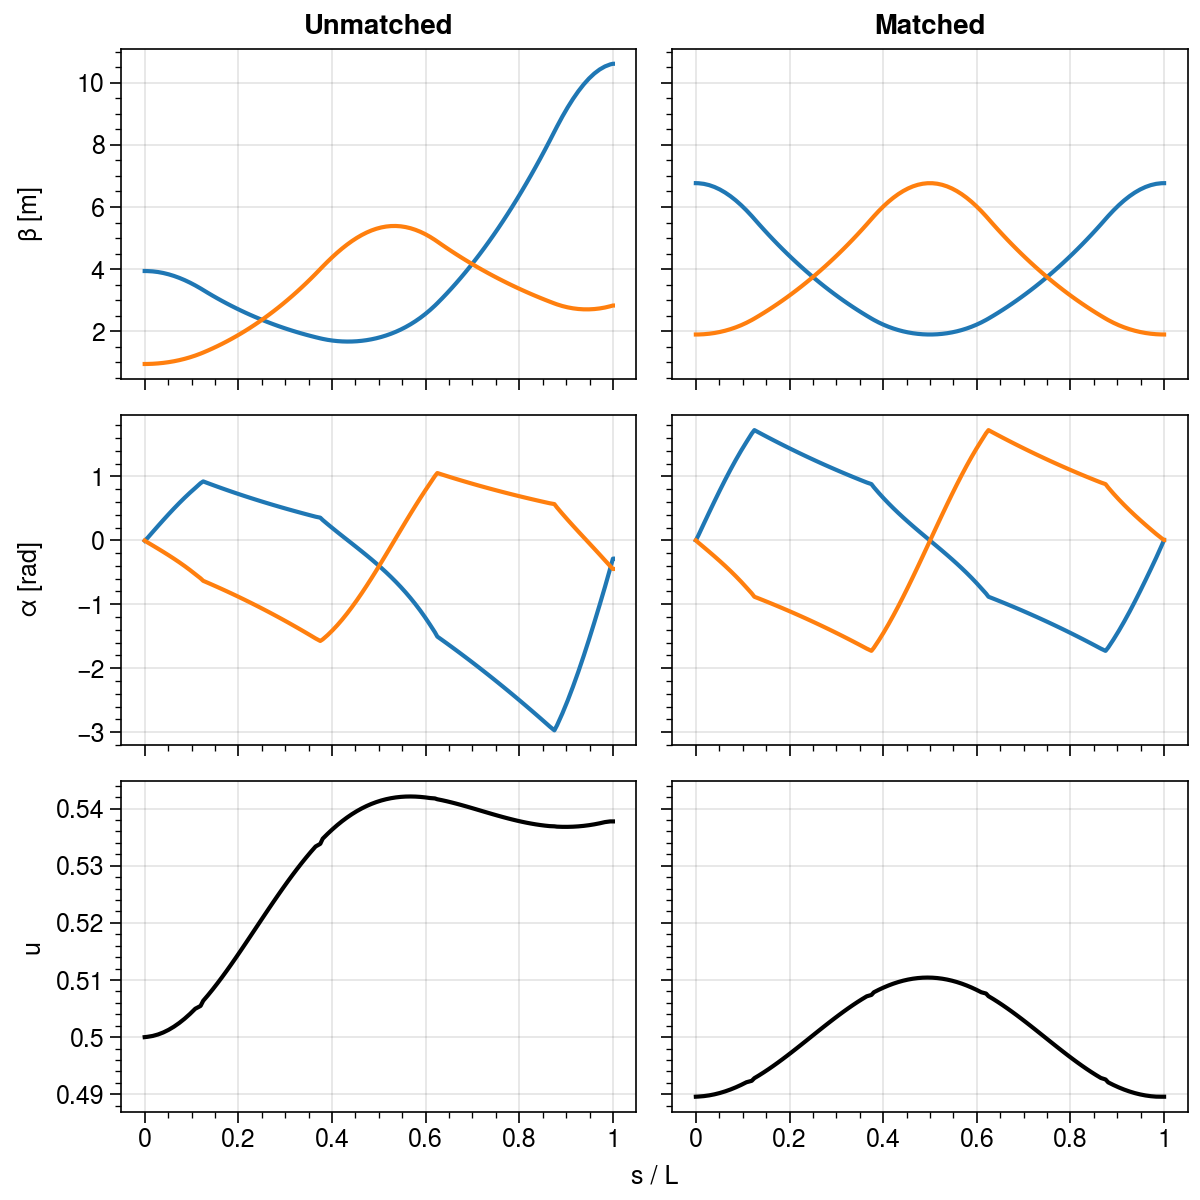

In [66]:
fig, axes = setup_figure(3)
for i, stats in enumerate(stats_list):
    stats.twiss4D[['s/L','bx','by']].plot('s/L', ax=axes[0, i], **plt_kws)
    stats.twiss4D[['s/L','ax','ay']].plot('s/L', ax=axes[1, i], **plt_kws)
    stats.twiss4D[['s/L', 'u']].plot('s/L', ax=axes[2, i], color='k', **plt_kws)
ylabels = [r'$\beta$ [m]', r'$\alpha$ [rad]', 'u']
set_labels(axes[:, 0], ylabels, 'ylabel')
save('twiss4D', fig_dir, dpi=dpi)

## Phase advance 

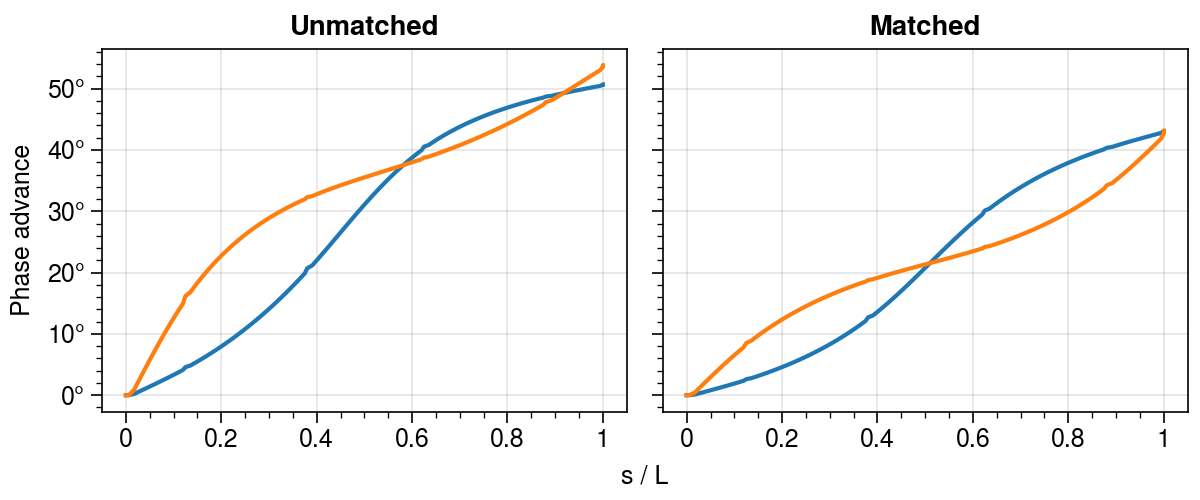

In [67]:
fig, axes = setup_figure(1)
for ax, stats in zip(axes, stats_list):
    stats.twiss2D[['s/L','mux','muy']].plot('s/L', ax=ax, **plt_kws)
ax.format(ylabel='Phase advance', yformatter='deg')
save('phase_adv', fig_dir, dpi=dpi)

## Phase diff (nu) 

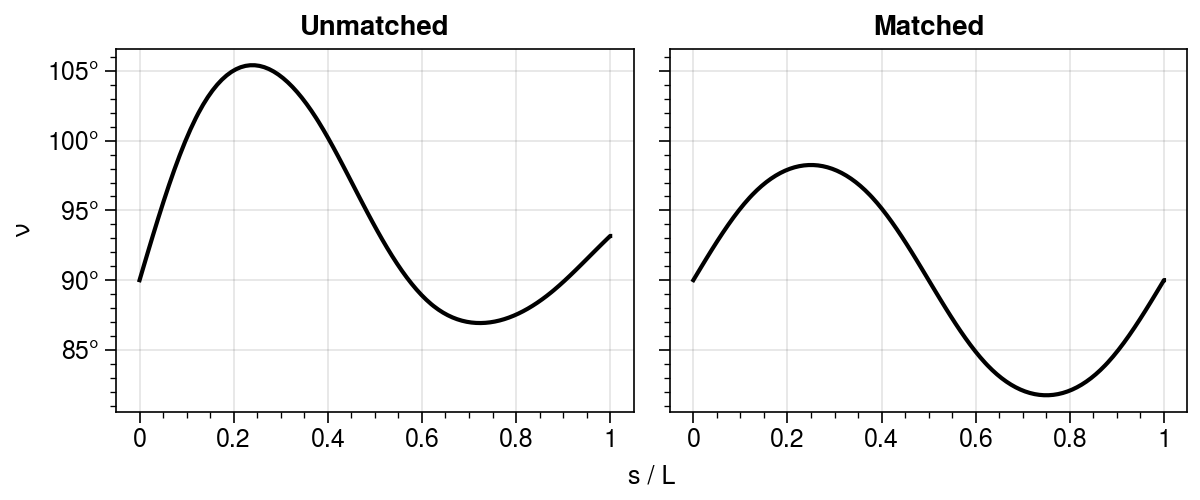

In [68]:
fig, axes = setup_figure(1)
for ax, stats in zip(axes, stats_list):
    stats.twiss4D[['s/L','nu']].plot('s/L', ax=ax, color='k', **plt_kws)
axes.format(ylabel=r'$\nu$', yformatter='deg')
save('twiss4D-nu', fig_dir, dpi=dpi)

# Moments 

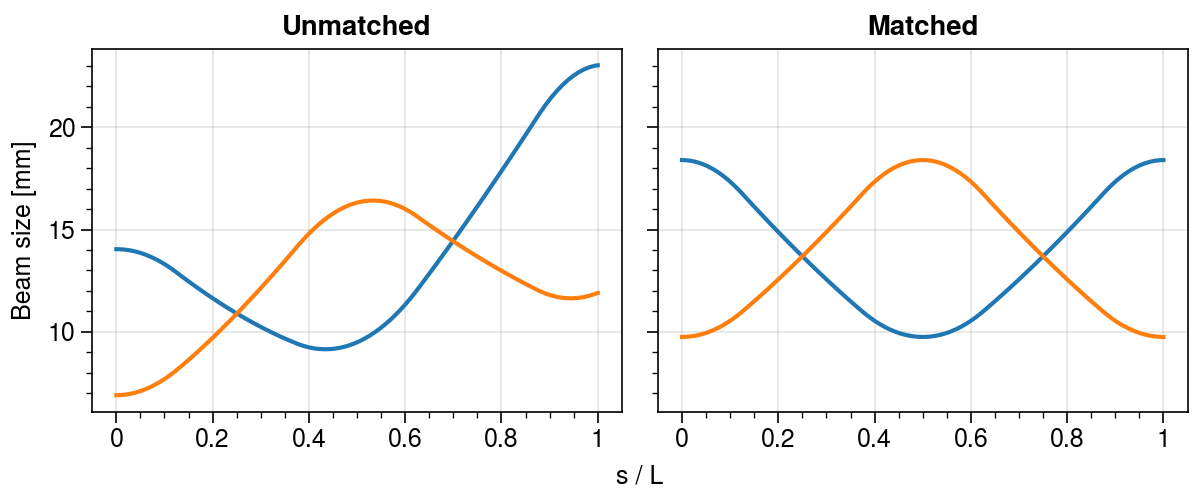

In [69]:
fig, axes = setup_figure(1)
for ax, stats in zip(axes, stats_list):
    stats.moments[['s/L','x_rms','y_rms']].plot('s/L', ax=ax, **plt_kws)
ax.format(ylabel='Beam size [mm]')
save('beamsize', fig_dir, dpi=dpi)

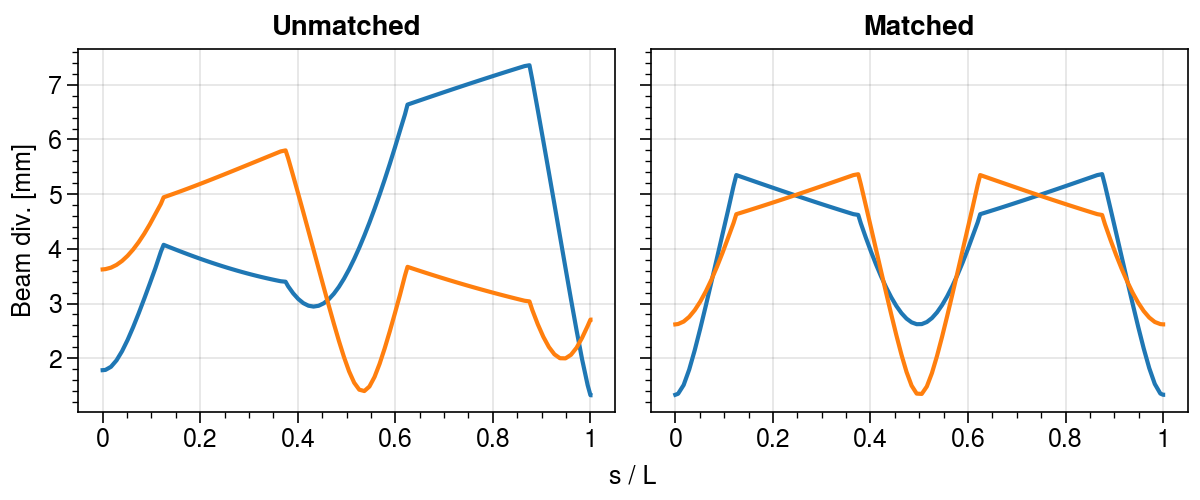

In [70]:
fig, axes = setup_figure(1)
for ax, stats in zip(axes, stats_list):
    stats.moments[['s/L','xp_rms','yp_rms']].plot('s/L', ax=ax, **plt_kws)
ax.format(ylabel='Beam div. [mm]')
save('beamdiv', fig_dir, dpi=dpi)

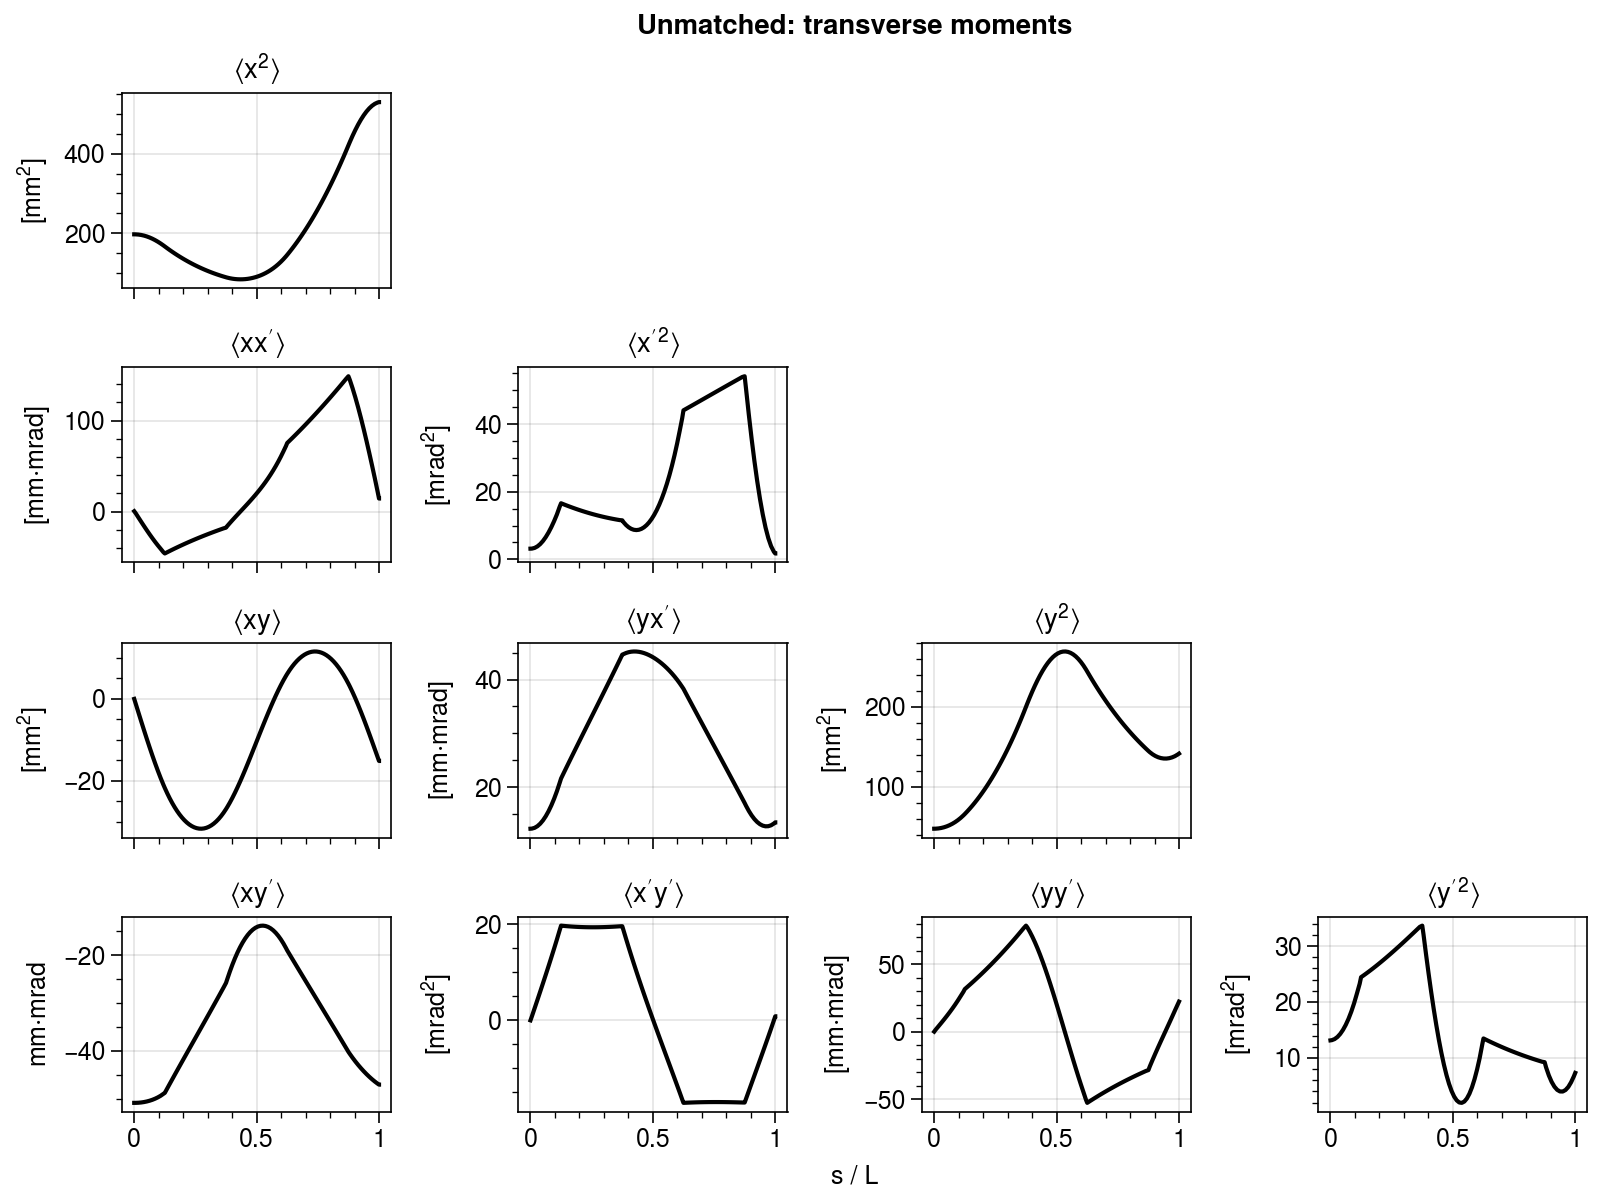

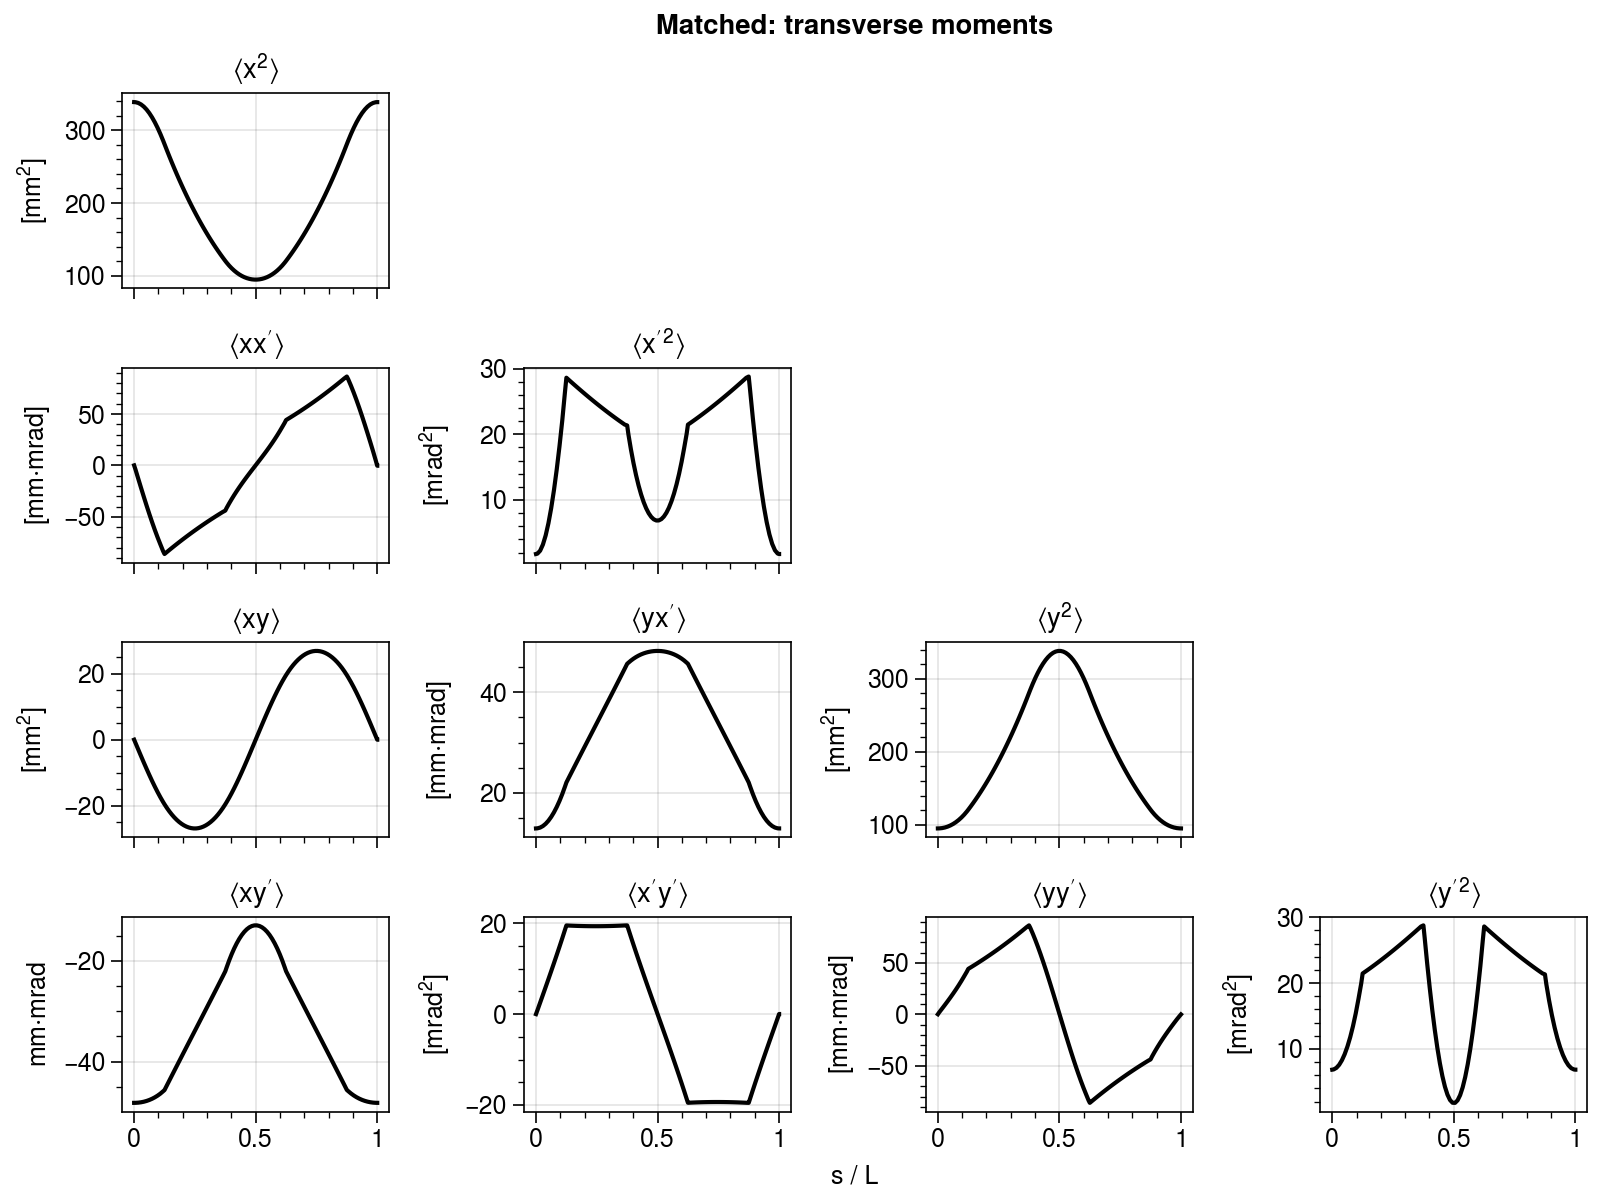

In [71]:
for stats, title in zip(stats_list, titles):
    fig, axes = plot.subplots(nrows=4, ncols=4, sharey=False, figsize=(8, 6), 
                              spany=False, aligny=True)
    myplt.make_lower_triangular(axes)
    axes.format(xlabel='s / L', suptitle='{}: transverse moments'.format(title))

    for i in range(4):
        for j in range(i + 1):
            ax = axes[i, j]
            col = utils.get_moments_key(i, j)
            stats.moments[['s/L', col]].plot('s/L', ax=ax, color='k', **plt_kws)
            ax.format(title=utils.get_moments_label(i, j))

    set_labels(axes[0:, 0], [r'[mm$^2$]', r'[mm$\cdot$mrad]', r'[mm$^2$]', r'mm$\cdot$mrad'], 'ylabel')
    set_labels(axes[1:, 1], [r'[mrad$^2$]', r'[mm$\cdot$mrad]', r'[mrad$^2$]'], 'ylabel')
    set_labels(axes[2:, 2], [r'[mm$^2$]', r'[mm$\cdot$mrad]'], 'ylabel')
    set_labels(axes[3:, 3], [r'[mrad$^2$]'], 'ylabel')

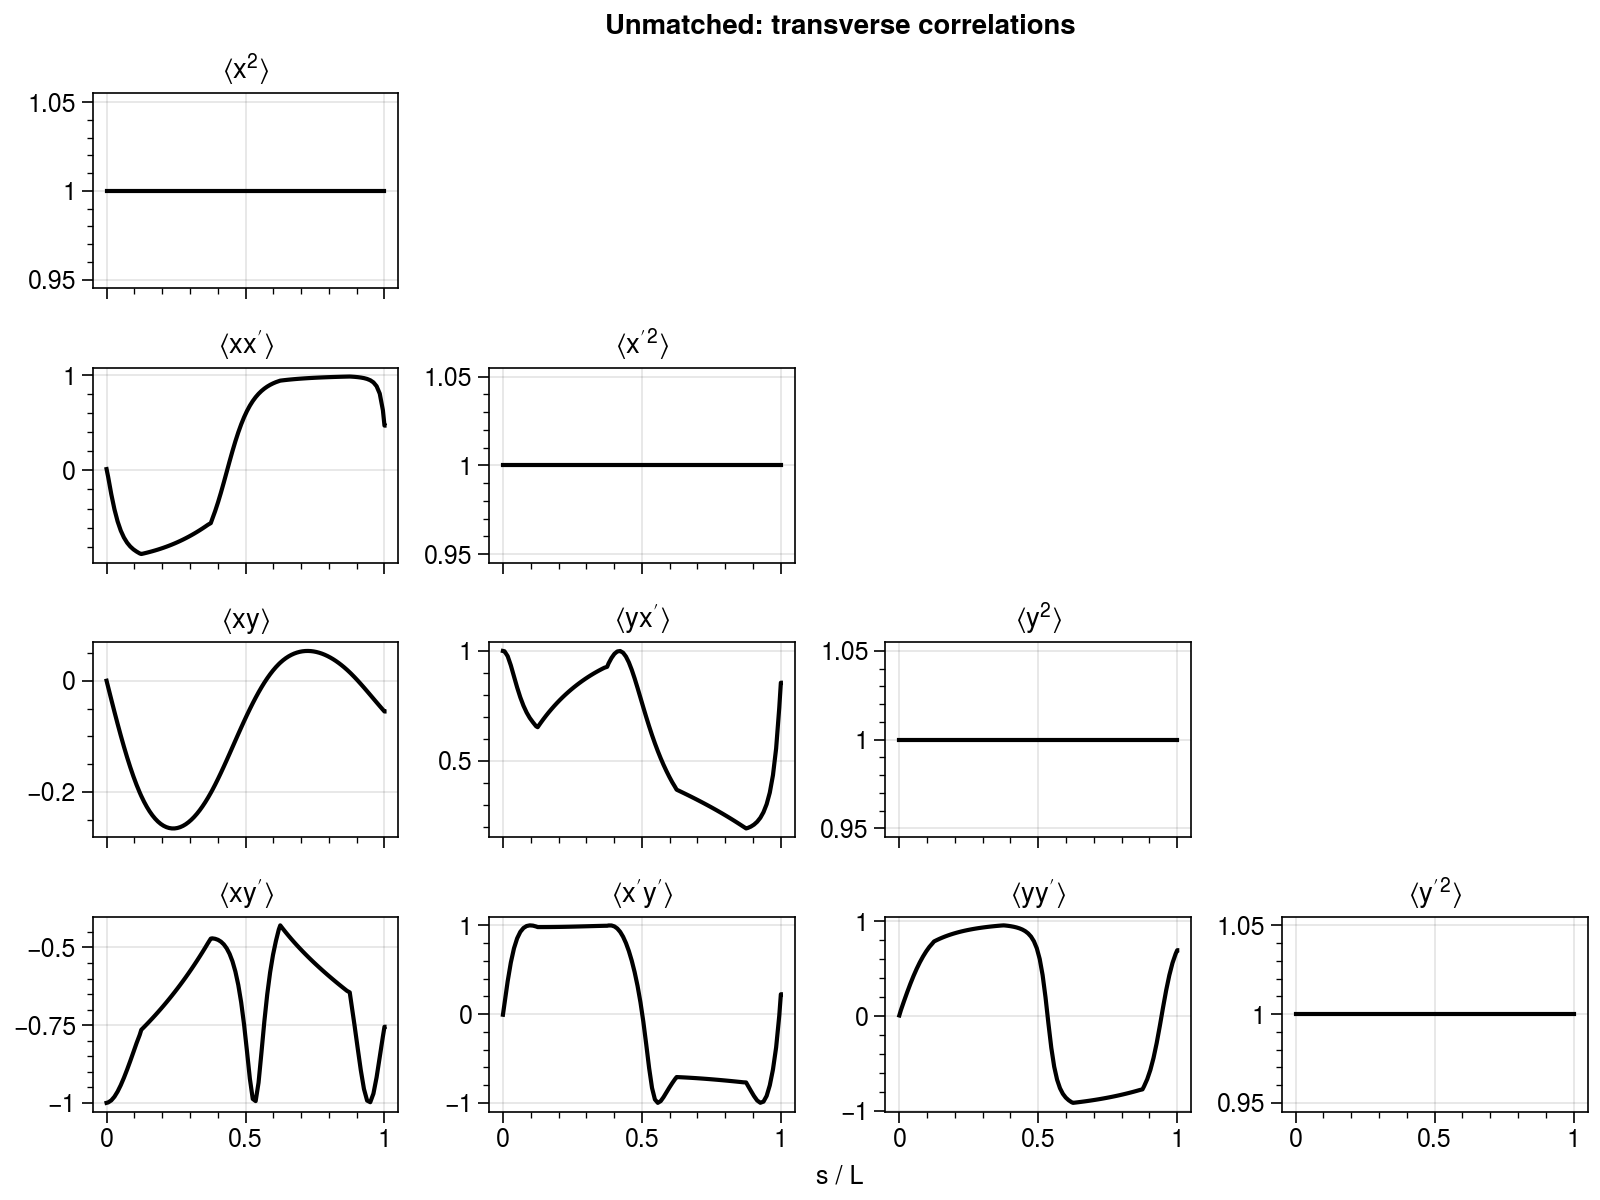

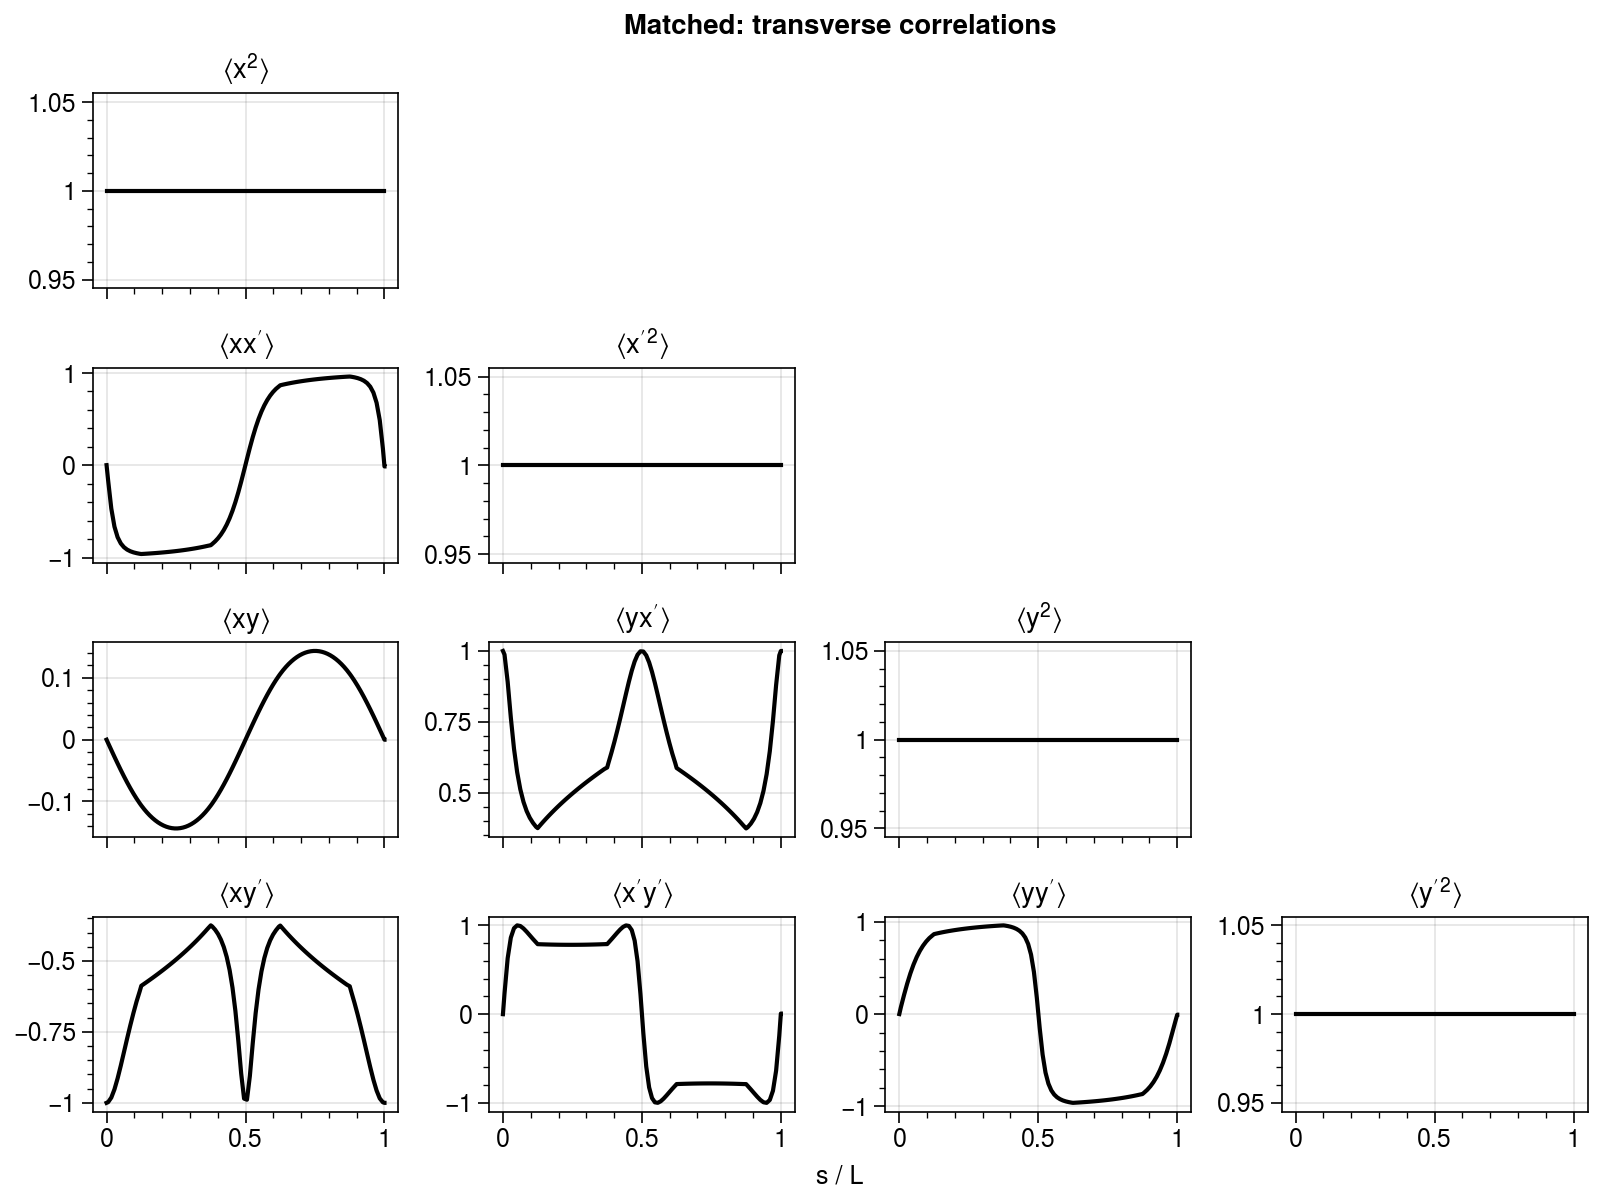

In [72]:
for stats, title in zip(stats_list, titles):
    fig, axes = plot.subplots(nrows=4, ncols=4, sharey=False, figsize=(8, 6), 
                              spany=False, aligny=True)
    myplt.make_lower_triangular(axes)
    axes.format(xlabel='s / L', suptitle='{}: transverse correlations'.format(title))

    for i in range(4):
        for j in range(i + 1):
            ax = axes[i, j]
            col = utils.get_moments_key(i, j)
            stats.corr[['s/L', col]].plot('s/L', ax=ax, color='k', **plt_kws)
            ax.format(title=utils.get_moments_label(i, j))

# Beam orientation

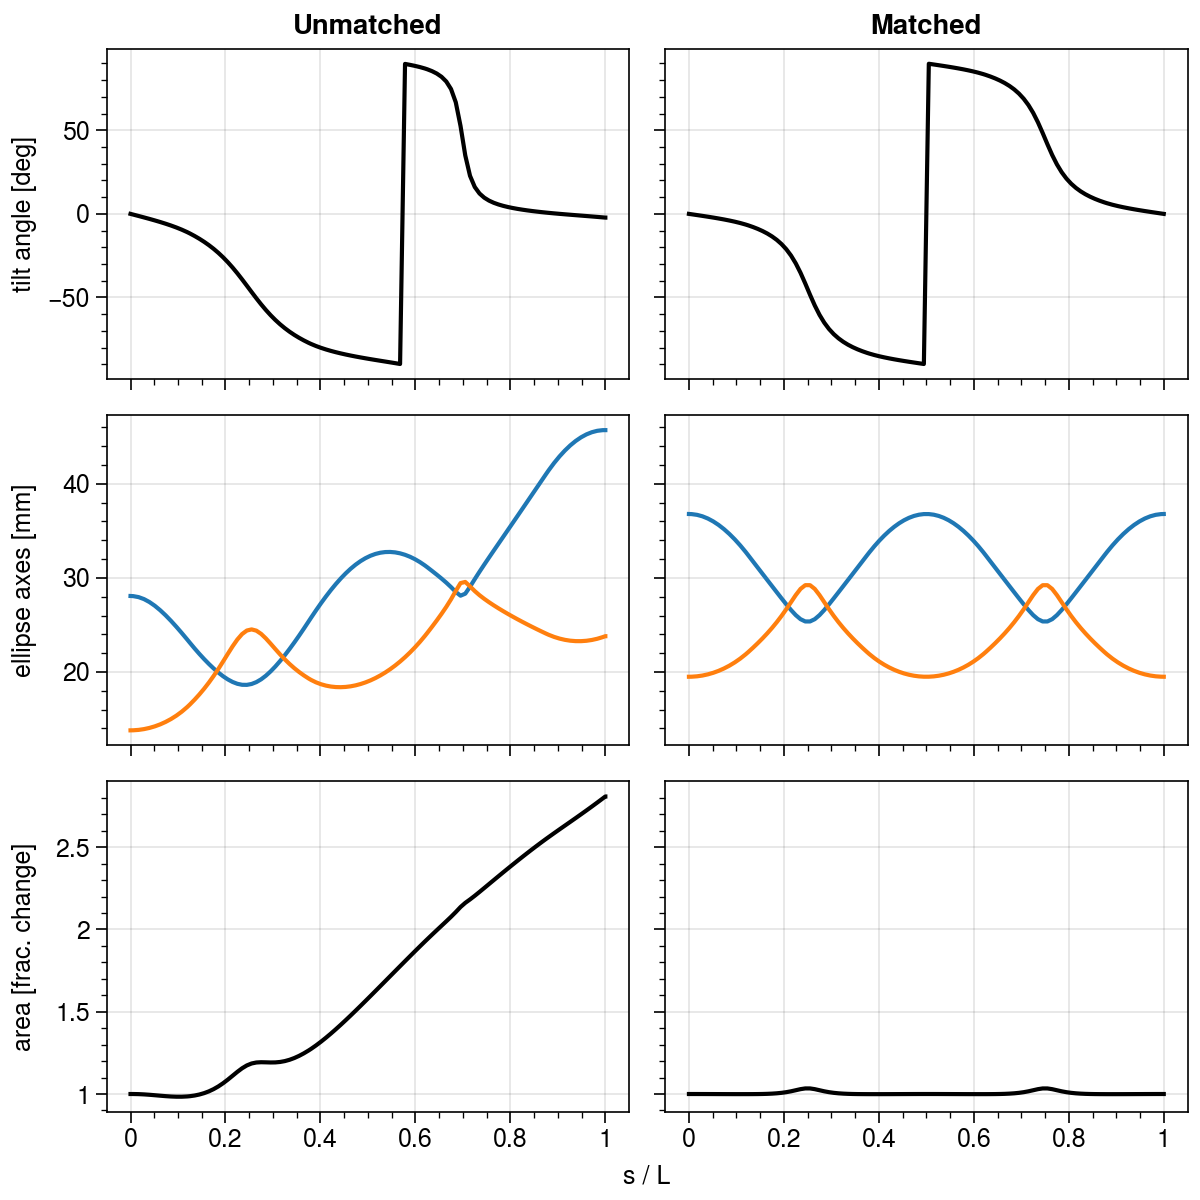

In [73]:
fig, axes = setup_figure(3)
for i, stats in enumerate(stats_list):
    stats.realspace[['s/L','angle']].plot('s/L', ax=axes[0, i], color='k', **plt_kws)
    stats.realspace[['s/L','cx','cy']].plot('s/L', ax=axes[1, i], **plt_kws)
    stats.realspace[['s/L','area_rel']].plot('s/L', ax=axes[2, i], color='k', **plt_kws)
ylabels = ['tilt angle [deg]', 'ellipse axes [mm]', 'area [frac. change]']
set_labels(axes[:, 0], ylabels, 'ylabel')
save('realspace_orientation', fig_dir, dpi=dpi)

# Miscellaneous 

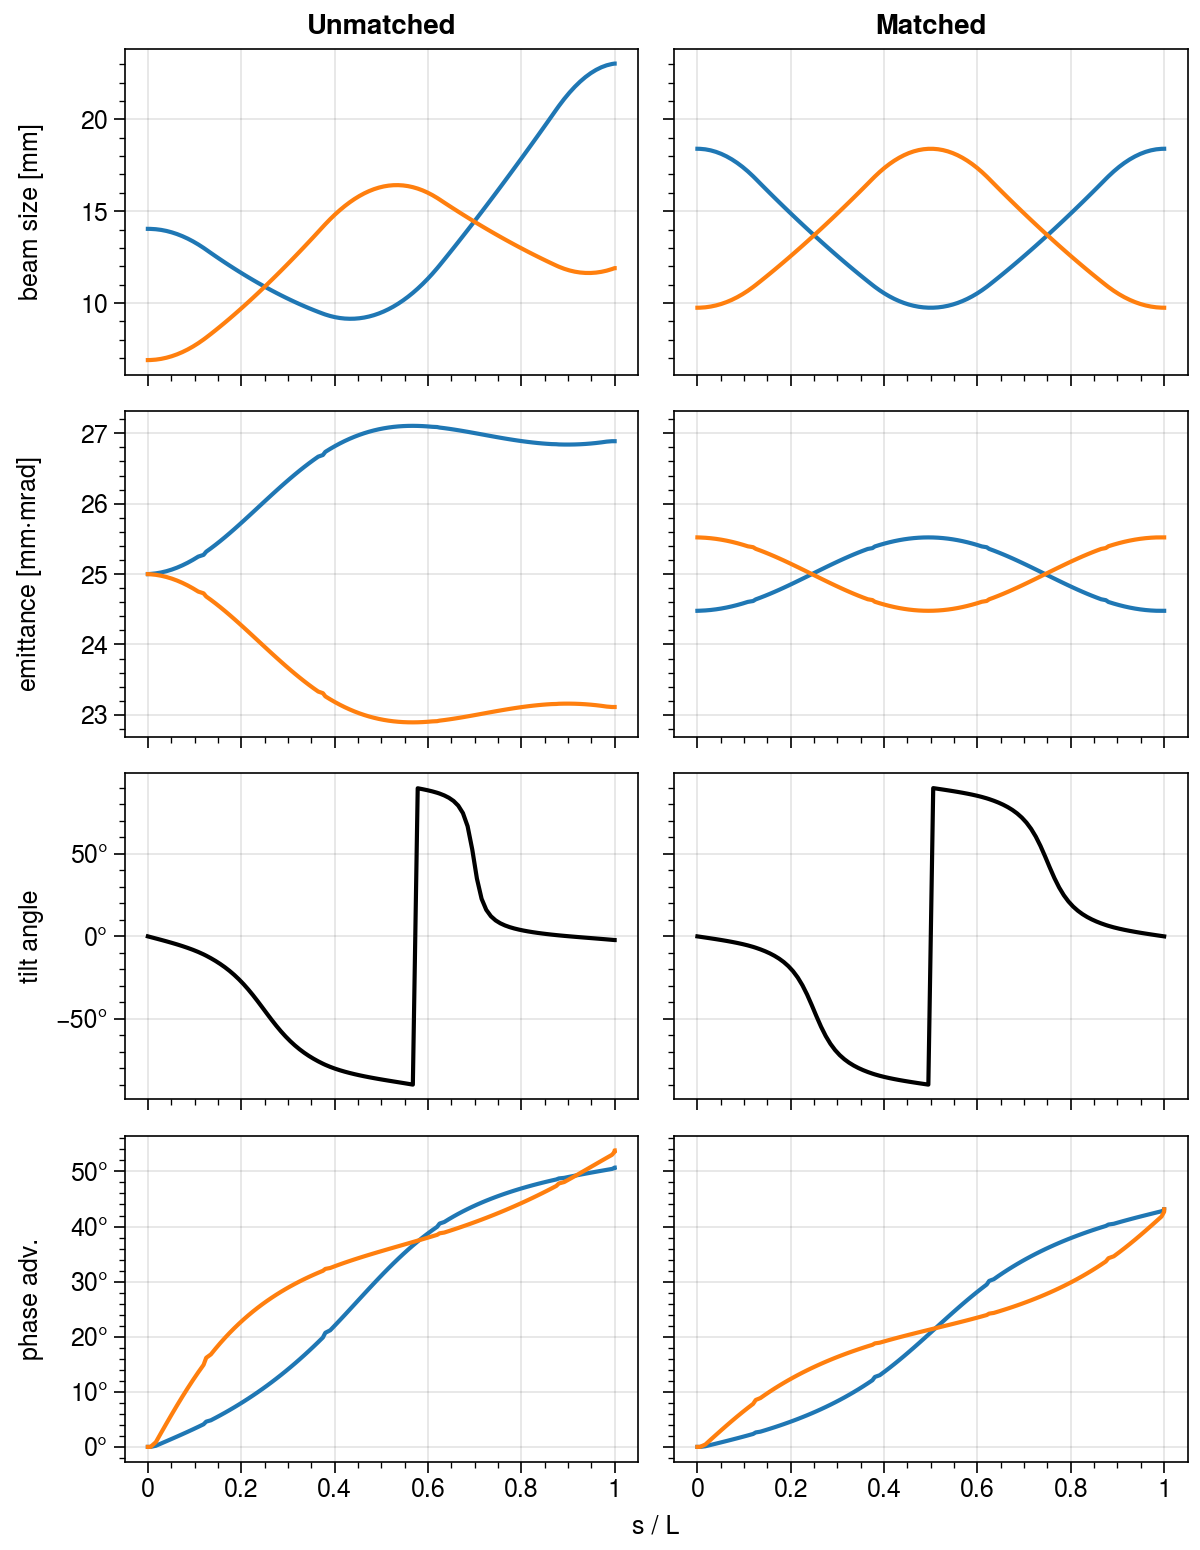

In [79]:
fig, axes = setup_figure(4)
for i, stats in enumerate(stats_list):
    stats.moments[['s/L','x_rms','y_rms']].plot('s/L', ax=axes[0, i], **plt_kws)
    stats.twiss2D[['s/L','ex','ey']].plot('s/L', ax=axes[1, i], **plt_kws)
    stats.realspace[['s/L','angle']].plot('s/L', color='k', ax=axes[2, i], **plt_kws)
    stats.twiss2D[['s/L','mux','muy']].plot('s/L', ax=axes[3, i], **plt_kws)

ylabels = ['beam size [mm]', r'emittance [mm$\cdot$mrad]', 'tilt angle', 'phase adv.']
set_labels(axes[:, 0], ylabels, 'ylabel')
axes[2:, :].format(yformatter='deg')
save('vert', fig_dir, dpi=dpi)

# Phase space projections 
Show the beam at the lattice entrance.

## Snapshots 

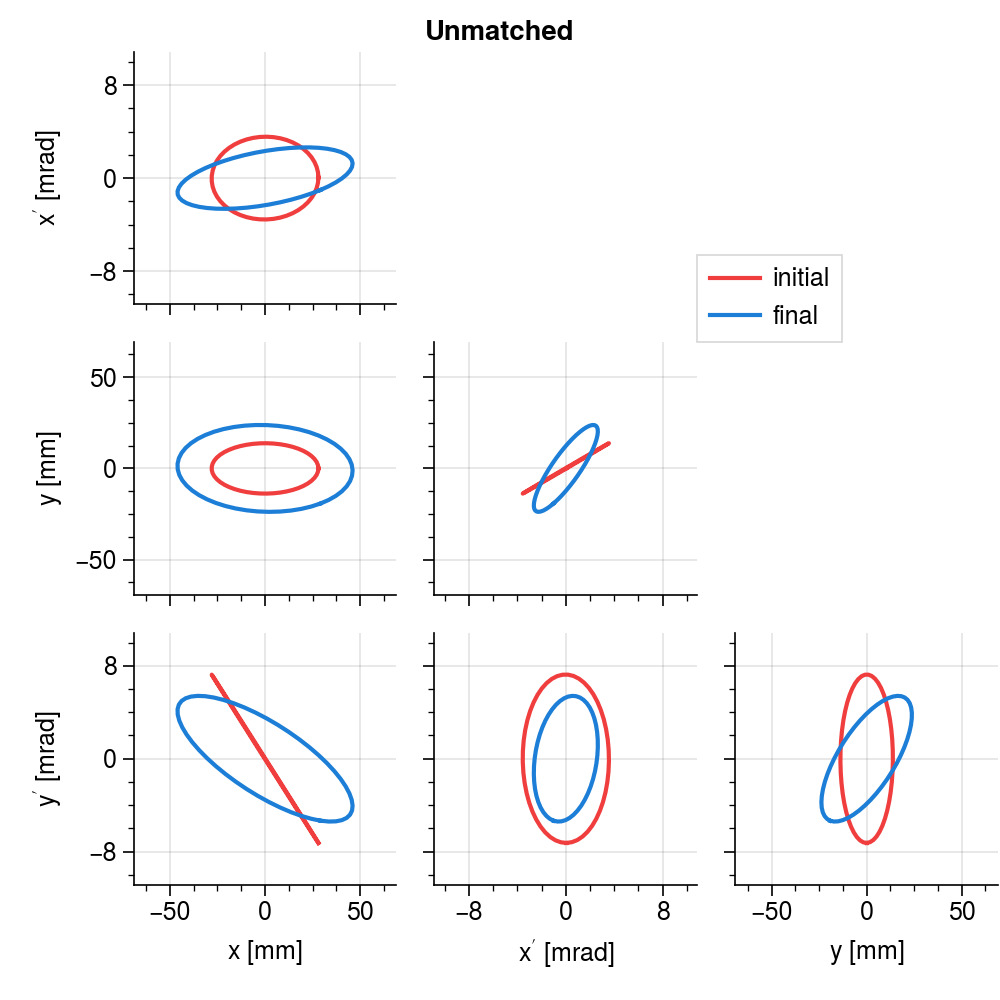

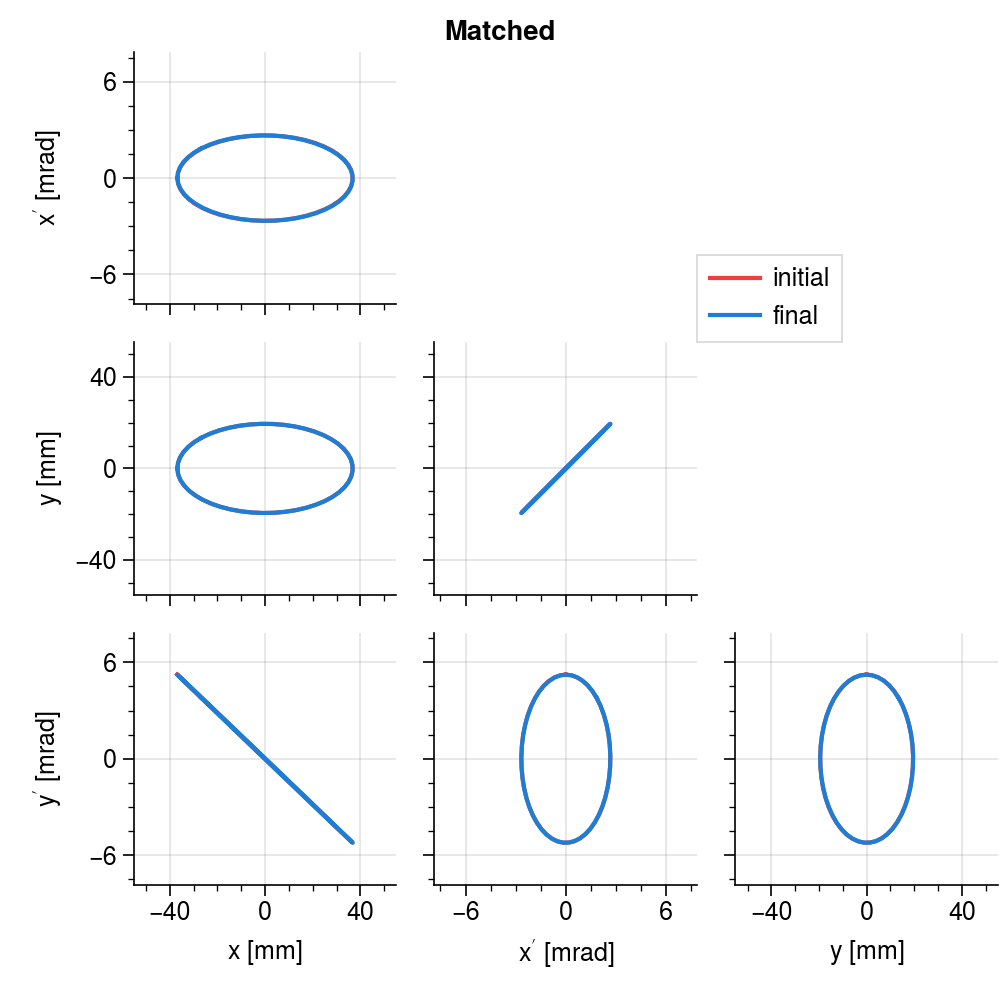

In [75]:
for i, env_params in enumerate(env_params_list):
    axes = myplt.corner_env(
        env_params[[0, -1]], cmap=plot.Colormap(('red7', 'blue7')),
        legend_kws=dict(labels=['initial','final'], loc=(1, 1))
    )
    plt.suptitle(titles[i])
    save('init_final_{}'.format(titles[i]), fig_dir, dpi=dpi)

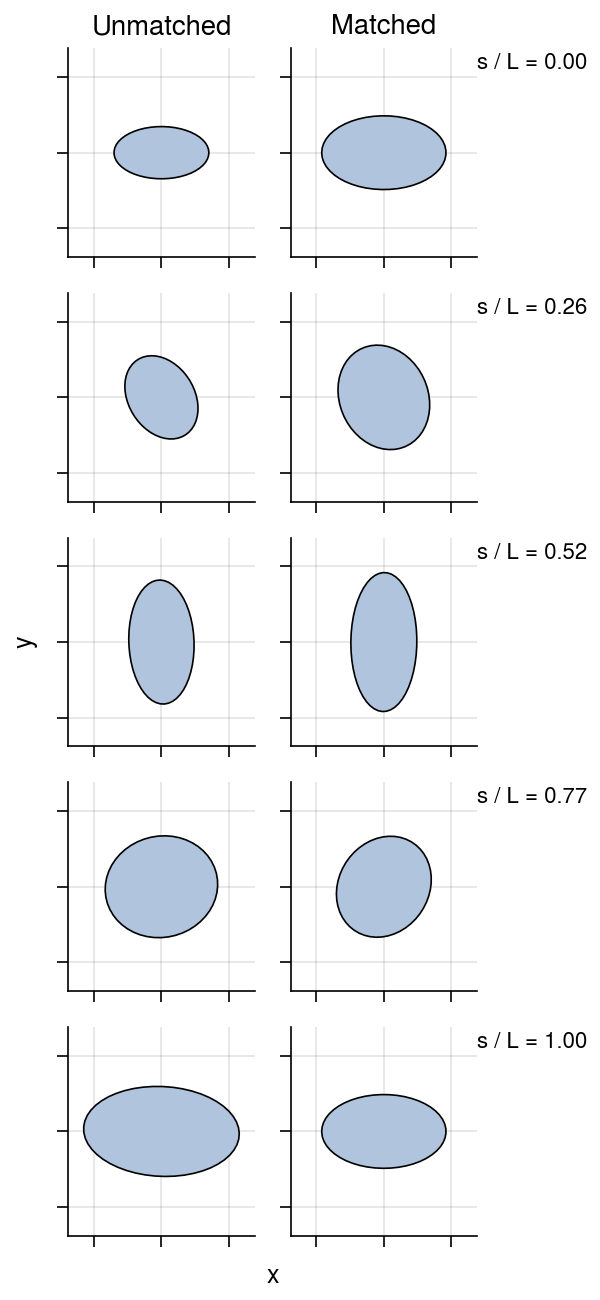

In [76]:
nframes = len(positions_normed)
idx = [0, nframes//4, nframes//2, 3*nframes//4, nframes - 1]

fig, axes = plot.subplots(nrows=len(idx), ncols=2, figsize=(3, 6.5))
myplt.despine(axes)
myplt.set_labels(axes, titles, 'title')

for i, env_params in enumerate(env_params_list):
    ellipse_coords_list = ea.get_ellipse_coords(env_params[idx])
    s_list = positions_normed[idx]
    umax, upmax = myplt.get_u_up_max_global(ellipse_coords_list)
    umax *= 1.5

    for ax, X, s in zip(axes[:, i], ellipse_coords_list, s_list):
        ax.fill(X[:, 0], X[:, 2], ec='k', fc='lightsteelblue', zorder=2)
        if i == 1:
            ax.annotate('s / L = {:.2f}'.format(s), xy=(1, 0.9), 
                        xycoords='axes fraction', fontsize=8)

axes.format(
    ylabel=r'$y$', xlabel=r'$x$', titleloc='center',
    xticklabels=[], yticklabels=[], 
    xlocator=('maxn', 3), ylocator=('maxn', 3),
    xlim=(-umax, umax), ylim=(-umax, umax),
    xtickminor=False, ytickminor=False
)

save('snapshots', fig_dir, dpi=dpi)

## Animation

# Transfer matrix 

## Eigenvalues 

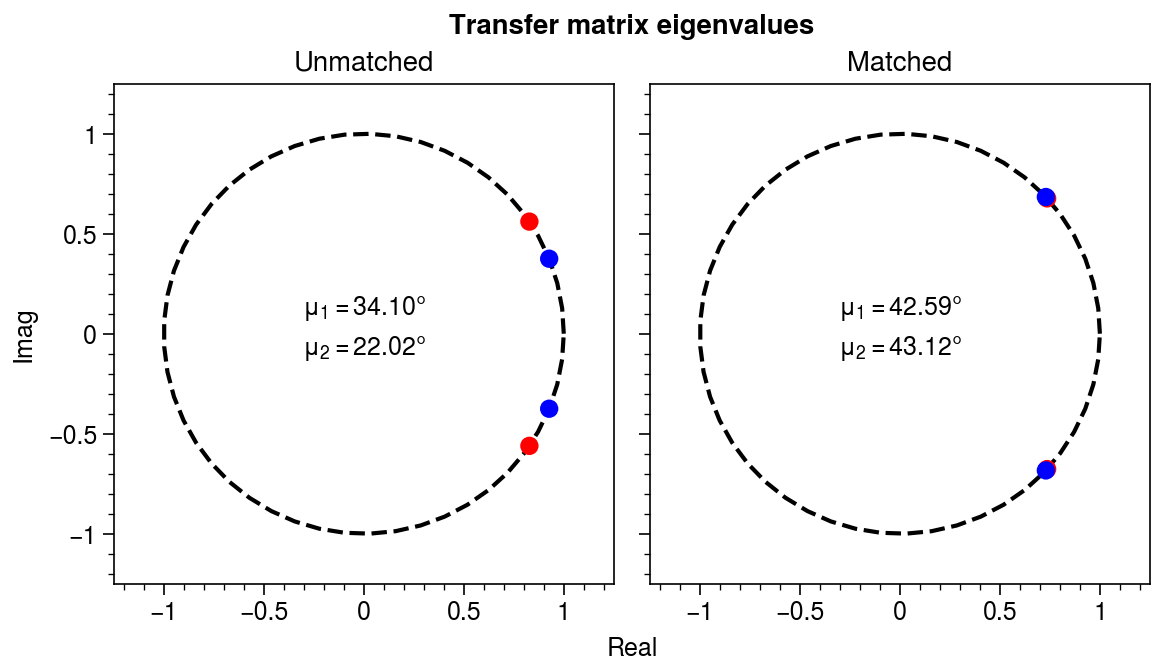

In [77]:
psi = np.linspace(0, 2*np.pi, 50)
x_circ, y_circ = np.cos(psi), np.sin(psi)

fig, axes = plot.subplots(ncols=2)
set_labels(axes, titles, 'title')
scale = 1.25
axes.format(grid=False, 
            xlocator=('maxn', 5), ylocator=('maxn', 5),
            ylim=(-scale, scale), xlim=(-scale, scale), 
            xlabel='Real', ylabel='Imag', 
            suptitle='Transfer matrix eigenvalues')

for ax, M in zip(axes, transfer_matrices):
    eigvals = np.linalg.eigvals(M)
    eigtunes = np.degrees(np.arccos(eigvals.real))
    ax.plot(x_circ, y_circ, 'k--', zorder=0)
    ax.scatter(eigvals.real, eigvals.imag, c=['r','r','b','b'])
    ax.annotate(r'$\mu_1 = {:.2f}\degree$'.format(eigtunes[0]), xy=(0, +0.1),
                horizontalalignment='center')
    ax.annotate(r'$\mu_2 = {:.2f}\degree$'.format(eigtunes[2]), xy=(0, -0.1),
                horizontalalignment='center')
    
for ax in axes:
    ax.invert_xaxis()
save('eigvals', fig_dir, dpi=dpi)

## Eigenvectors 
Note: the plot windows are not square.

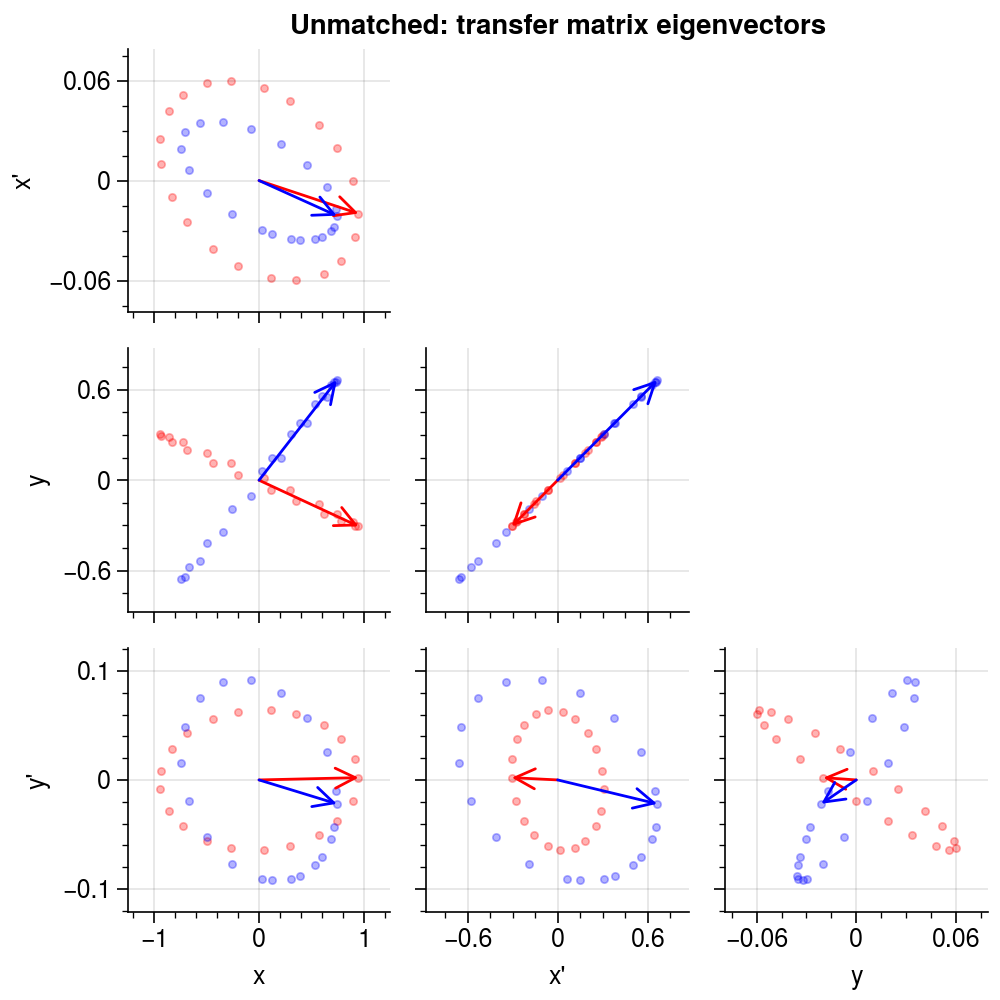

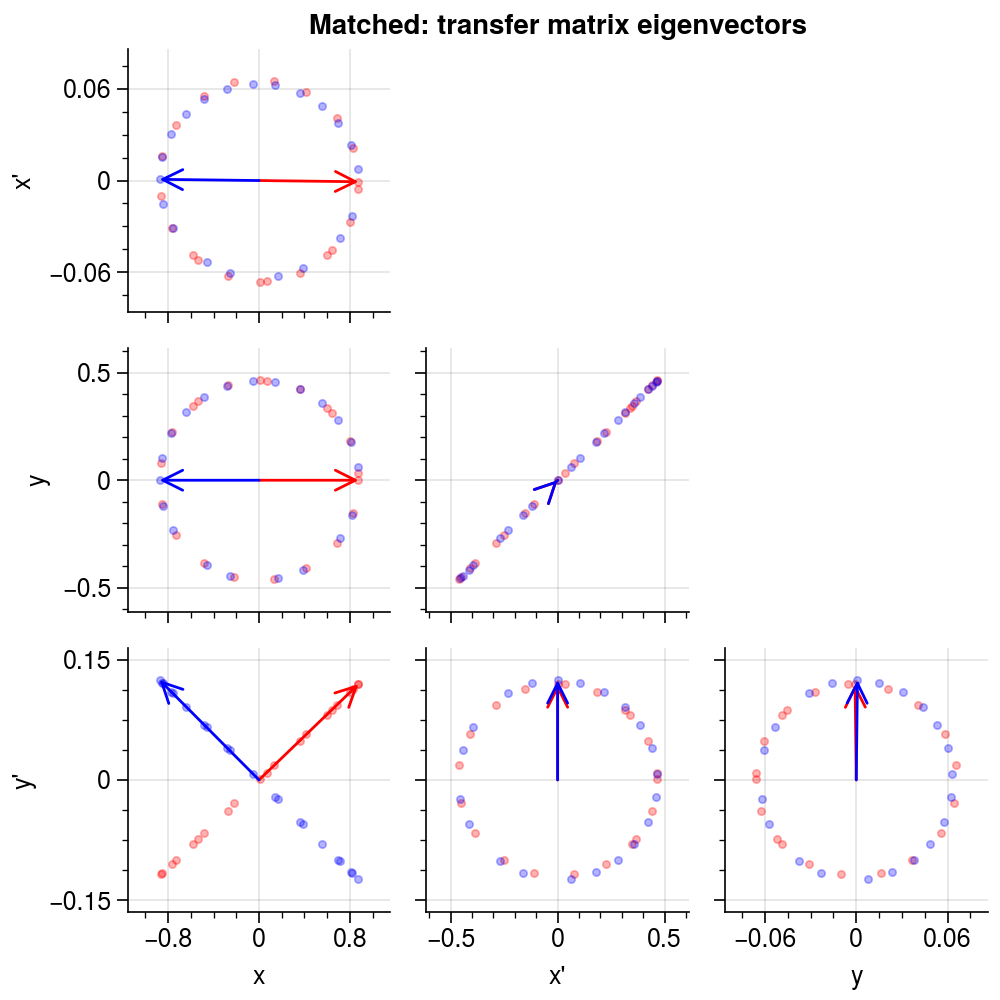

In [78]:
for M, title in zip(transfer_matrices, titles):
    
    # Set up figure
    fig, axes = plot.subplots(nrows=3, ncols=3, figsize=(5, 5), span=False)
    axes.format(grid=True, suptitle='{}: transfer matrix eigenvectors'.format(title),
                xlocator=('maxn', 3), ylocator=('maxn', 3))
    myplt.make_lower_triangular(axes)
    myplt.despine(axes)

    labels = ["x", "x'", "y", "y'"]
    xlabels, ylabels = labels[:-1], labels[1:]
    set_labels(axes[-1, :], xlabels, 'xlabel')
    set_labels(axes[:, 0], ylabels, 'ylabel')

    # Plot eigenvectors and their trajectories
    for i in range(3):
        for j in range(3):
            if i >= j:
                ax = axes[i, j]
                yvar = ['xp', 'y', 'yp'][i]
                xvar = ['x', 'y', 'xp'][j]
                myplt.eigvec_trajectory(ax, M, xvar, yvar, s=7, lw=1)

    # Zoom out a bit
    for i in range(3):
        ymin, ymax = axes[i, 0].get_ylim()
        xmin, xmax = axes[-1, i].get_xlim()
        scale = 1.2
        axes[i, :].format(ylim=(-scale*ymax, scale*ymax))
        axes[:, i].format(xlim=(-scale*xmax, scale*xmax))

    save('eigvecs', fig_dir, dpi=dpi)